In [4]:
import pandas as pd
import ast
from scipy.spatial.distance import cosine, euclidean, hamming
from sklearn.preprocessing import normalize
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from time import time
import tensorflow as tf

2022-07-08 17:08:30.279146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-08 17:08:30.279228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
recipe = pd.read_csv('raw-data_recipe.csv')
recipe = recipe.drop(columns=['image_url', 'cooking_directions', 'reviews'])
recipe.head()

,recipe_id,recipe_name,aver_rate,review_nums,ingredients,nutritions
0,222388,Homemade Bacon,5.000000,3,pork belly^smoked paprika^kosher salt^ground b...,"{u'niacin': {u'hasCompleteData': False, u'name..."
1,240488,"Pork Loin, Apples, and Sauerkraut",4.764706,29,sauerkraut drained^Granny Smith apples sliced^...,"{u'niacin': {u'hasCompleteData': False, u'name..."
2,218939,Foolproof Rosemary Chicken Wings,4.571429,12,chicken wings^sprigs rosemary^head garlic^oliv...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
3,87211,Chicken Pesto Paninis,4.625000,163,focaccia bread quartered^prepared basil pesto^...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
4,245714,Potato Bacon Pizza,4.500000,2,red potatoes^strips bacon^Sauce:^heavy whippin...,"{u'niacin': {u'hasCompleteData': True, u'name'..."


In [4]:
# round average rating into 2 decimal places
def avg_rate(col):
    return f'{col:.2f}'

In [5]:
recipe.aver_rate = recipe.aver_rate.apply(avg_rate)
recipe.head()

,recipe_id,recipe_name,aver_rate,review_nums,ingredients,nutritions
0,222388,Homemade Bacon,5.00,3,pork belly^smoked paprika^kosher salt^ground b...,"{u'niacin': {u'hasCompleteData': False, u'name..."
1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,29,sauerkraut drained^Granny Smith apples sliced^...,"{u'niacin': {u'hasCompleteData': False, u'name..."
2,218939,Foolproof Rosemary Chicken Wings,4.57,12,chicken wings^sprigs rosemary^head garlic^oliv...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
3,87211,Chicken Pesto Paninis,4.62,163,focaccia bread quartered^prepared basil pesto^...,"{u'niacin': {u'hasCompleteData': True, u'name'..."
4,245714,Potato Bacon Pizza,4.50,2,red potatoes^strips bacon^Sauce:^heavy whippin...,"{u'niacin': {u'hasCompleteData': True, u'name'..."


In [6]:
recipe.aver_rate = recipe.aver_rate.astype(float)
recipe.dtypes

recipe_id        int64
recipe_name     object
aver_rate      float64
review_nums      int64
ingredients     object
nutritions      object
dtype: object

In [9]:
recipe.nutritions[0]

"{u'niacin': {u'hasCompleteData': False, u'name': u'Niacin Equivalents', u'amount': 9.319291, u'percentDailyValue': u'72', u'displayValue': u'9', u'unit': u'mg'}, u'sugars': {u'hasCompleteData': True, u'name': u'Sugars', u'amount': 0.09355932, u'percentDailyValue': u'0', u'displayValue': u'0.1', u'unit': u'g'}, u'sodium': {u'hasCompleteData': True, u'name': u'Sodium', u'amount': 2017.13, u'percentDailyValue': u'81', u'displayValue': u'2017', u'unit': u'mg'}, u'carbohydrates': {u'hasCompleteData': True, u'name': u'Carbohydrates', u'amount': 1.797819, u'percentDailyValue': u'< 1', u'displayValue': u'1.8', u'unit': u'g'}, u'vitaminB6': {u'hasCompleteData': False, u'name': u'Vitamin B6', u'amount': 0.2329798, u'percentDailyValue': u'15', u'displayValue': u'< 1', u'unit': u'mg'}, u'calories': {u'hasCompleteData': True, u'name': u'Calories', u'amount': 308.1481, u'percentDailyValue': u'15', u'displayValue': u'308', u'unit': u'kcal'}, u'thiamin': {u'hasCompleteData': False, u'name': u'Thiamin

In [10]:
# turn nutritions data from string to dictionary
list_of_dict = []

for row in recipe.nutritions:
    list_of_dict.append(ast.literal_eval(row))

In [11]:
# extract percent daily values for selected nutritions
calories_list = []
fat_list = []
carbohydrates_list = []
protein_list = []
cholesterol_list = []
sodium_list = []
fiber_list = []

for x in range(len(list_of_dict)):
    calories_list.append(list_of_dict[x]['calories']['percentDailyValue'])
    fat_list.append(list_of_dict[x]['fat']['percentDailyValue'])
    carbohydrates_list.append(list_of_dict[x]['carbohydrates']['percentDailyValue'])
    protein_list.append(list_of_dict[x]['protein']['percentDailyValue'])
    cholesterol_list.append(list_of_dict[x]['cholesterol']['percentDailyValue'])
    sodium_list.append(list_of_dict[x]['sodium']['percentDailyValue'])
    fiber_list.append(list_of_dict[x]['fiber']['percentDailyValue'])

In [12]:
# group all the data into dataframe
data = {'calories': calories_list, 'fat': fat_list, 'carbohydrates': carbohydrates_list, 
       'protein': protein_list, 'cholesterol': cholesterol_list, 'sodium': sodium_list, 
       'fiber': fiber_list}

df = pd.DataFrame(data)
df.index = recipe['recipe_id']
df.head()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,15,36,< 1,42,21,81,2
240488,19,18,10,73,33,104,41
218939,17,36,2,48,24,31,4
87211,32,45,20,65,20,43,18
245714,8,12,5,14,7,8,3


In [13]:
df.isnull().sum()

calories         963
fat              963
carbohydrates    963
protein          963
cholesterol      963
sodium           963
fiber            963
dtype: int64

In [14]:
print(df.shape)
df = df.dropna()
df.shape

(49698, 7)


(48735, 7)

In [15]:
# impute string data into numeric value
def text_cleaning(cols):
    if cols == '< 1':
        return 1
    else:
        return cols

In [16]:
for col in df.columns:
    df[col] = df[col].apply(text_cleaning)

In [17]:
df.head()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,15,36,1,42,21,81,2
240488,19,18,10,73,33,104,41
218939,17,36,2,48,24,31,4
87211,32,45,20,65,20,43,18
245714,8,12,5,14,7,8,3


In [18]:
df.isna().sum()

calories         0
fat              0
carbohydrates    0
protein          0
cholesterol      0
sodium           0
fiber            0
dtype: int64

In [19]:
df.dtypes

calories         object
fat              object
carbohydrates    object
protein          object
cholesterol      object
sodium           object
fiber            object
dtype: object

In [20]:
df = df.apply(pd.to_numeric)
df.dtypes

calories         int64
fat              int64
carbohydrates    int64
protein          int64
cholesterol      int64
sodium           int64
fiber            int64
dtype: object

In [21]:
# normalized nutrition data by columns
df_normalized = pd.DataFrame(normalize(df, axis=0))
df_normalized.columns = df.columns
df_normalized.index = df.index
df_normalized.head()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560
240488,0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477
218939,0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120
87211,0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039
245714,0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840


In [22]:
df_normalized.tail()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222886,0.004609,0.000133,0.002110,0.000113,0.000000,0.000081,0.000000
25650,0.001383,0.001857,0.000703,0.000451,0.001855,0.000243,0.000280
23544,0.001844,0.000928,0.002814,0.001128,0.000428,0.000243,0.002239
170710,0.004609,0.004377,0.005627,0.001241,0.003568,0.000568,0.001400
79774,0.000461,0.000398,0.000703,0.000338,0.000000,0.001298,0.001680


In [23]:
# show recipe id, recipe name and image of selected recipe
def selected_recipe(recipe_id):
    image_path = "./raw-data-images/{}.jpg"
    image_path = image_path.format(recipe_id)
    
    img = tf.keras.utils.load_img(image_path)
    img = tf.keras.utils.img_to_array(img, dtype='int')
        
    fig, ax = plt.subplots(1,1)
    ax.imshow(img)
    ax.axis('off')
    
    recipe_df = recipe.set_index('recipe_id')
    x = "{}  {}".format(recipe_id, recipe_df.at[recipe_id, 'recipe_name'])
    ax.set_title(x)


In [24]:
"""
Nutrition Recommender based on different distance calculation approaches

df_normalized: normalized nutrition data
distance_method: distance calculation approach: e.g. cosine, euclidean, hamming
recipe_id: find similar recipes based on the selected recipe
N: Top N recipe(s)

return 1) nutrition data of selected recipe and Top N recommendation, 
2) recipe id, recipe name and image of Top N recommendation
"""

def nutrition_recommender(distance_method, recipe_id, N):
    start = time()
    
    allRecipes = pd.DataFrame(df_normalized.index)
    allRecipes = allRecipes[allRecipes.recipe_id != recipe_id]
    allRecipes["distance"] = allRecipes["recipe_id"].apply(lambda x: distance_method(df_normalized.loc[recipe_id], df_normalized.loc[x]))
    TopNRecommendation = allRecipes.sort_values(["distance"]).head(N).sort_values(by=['distance', 'recipe_id'])
    # sort by distance then recipe id, the smaller value of recipe id will be picked. 
    
    recipe_df = recipe.set_index('recipe_id')
    recipe_id = [recipe_id]
    recipe_list = []
    image_list = []
    image_path = "./raw-data-images/{}.jpg"
    for recipeid in TopNRecommendation.recipe_id:
        recipe_id.append(recipeid)   # list of recipe id of selected recipe and recommended recipe(s)
        recipe_list.append("{}  {}".format(recipeid, recipe_df.at[recipeid, 'recipe_name']))
        image_list.append(image_path.format(recipeid))
    
    image_array = []
    for imagepath in image_list:
        img = tf.keras.utils.load_img(imagepath)
        img = tf.keras.utils.img_to_array(img, dtype='int')
        image_array.append(img)
        
    fig = plt.figure(figsize=(15,15))
    gs1 = gridspec.GridSpec(1, N)
    axs = []
    for x in range(N):
        axs.append(fig.add_subplot(gs1[x]))
        axs[-1].imshow(image_array[x])
    [axi.set_axis_off() for axi in axs]
    for axi, x in zip(axs, recipe_list):
        axi.set_title(x)
    
    end = time()
    running_time = end - start
    print('time cost: %.5f sec' %running_time)
    return df_normalized.loc[recipe_id, :]

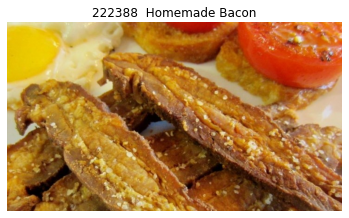

In [25]:
selected_recipe(222388)

time cost: 13.90599 sec


,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.00056
20628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75710,0.001613,0.002122,0.000352,0.002144,0.001570,0.002921,0.00028
255114,0.002765,0.003846,0.000352,0.003385,0.002855,0.005273,0.00056


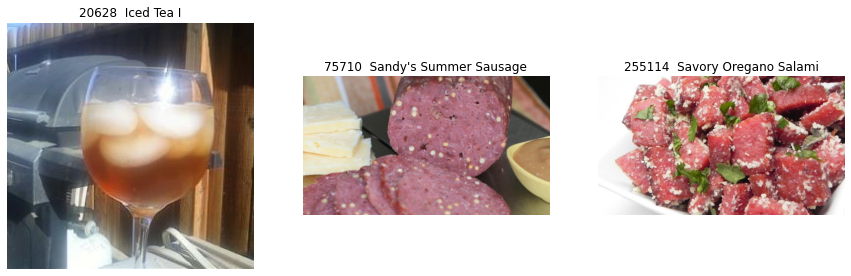

In [26]:
nutrition_recommender(cosine, 222388, 3)

time cost: 10.22325 sec


,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.00056
257428,0.004148,0.004775,0.001407,0.004739,0.002997,0.005841,0.00056
31026,0.004148,0.005173,0.001055,0.005529,0.003568,0.006085,0.00084
219048,0.002765,0.003846,0.000352,0.003611,0.002997,0.006734,0.00056


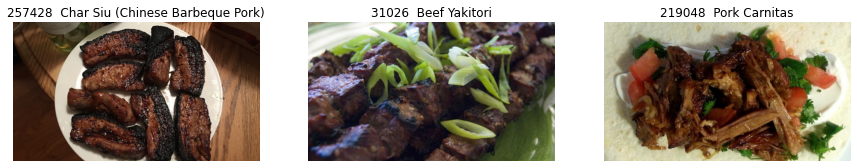

In [27]:
nutrition_recommender(euclidean, 222388, 3)

time cost: 12.99270 sec


,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.00056
16699,0.003457,0.004377,0.000352,0.005303,0.002997,0.002109,0.00056
256878,0.003457,0.004510,0.000352,0.004739,0.003425,0.002677,0.00056
257428,0.004148,0.004775,0.001407,0.004739,0.002997,0.005841,0.00056


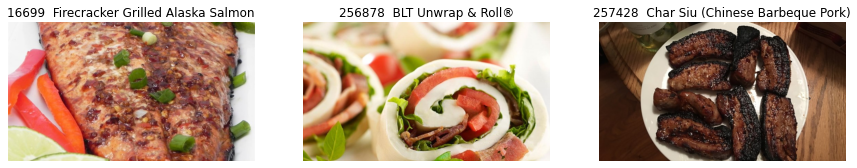

In [28]:
nutrition_recommender(hamming, 222388, 3)

In [29]:
"""
Hybrid Nutrition Recommender which integrates Top 2 recommendation from 3 different distance approaches 
(cosine, euclidean, hamming) and sort the results by selected criteria(s)

df_normalized: normalized nutrition data
recipe_id: find similar recipes based on the selected recipe
sort_order: must be in list, 4 options available: ['aver_rate'], ['review_nums'], ['aver_rate', 'review_nums'], ['review_nums', 'aver_rate']
N: Top N recipe(s)

return 1) recipe id, recipe name and image of Top N recommendation, 
2) nutrition data of selected recipe and Top N recommendation,
3) average rating and number of review of Top N recommendation
"""

def nutrition_hybrid_recommender(recipe_id, sort_order, N):
    start = time()
    
    allRecipes_cosine = pd.DataFrame(df_normalized.index)
    allRecipes_cosine = allRecipes_cosine[allRecipes_cosine.recipe_id != recipe_id]
    allRecipes_cosine["distance"] = allRecipes_cosine["recipe_id"].apply(lambda x: cosine(df_normalized.loc[recipe_id], df_normalized.loc[x]))
    
    allRecipes_euclidean = pd.DataFrame(df_normalized.index)
    allRecipes_euclidean = allRecipes_euclidean[allRecipes_euclidean.recipe_id != recipe_id]
    allRecipes_euclidean["distance"] = allRecipes_euclidean["recipe_id"].apply(lambda x: euclidean(df_normalized.loc[recipe_id], df_normalized.loc[x]))
    
    allRecipes_hamming = pd.DataFrame(df_normalized.index)
    allRecipes_hamming = allRecipes_hamming[allRecipes_hamming.recipe_id != recipe_id]
    allRecipes_hamming["distance"] = allRecipes_hamming["recipe_id"].apply(lambda x: hamming(df_normalized.loc[recipe_id], df_normalized.loc[x]))
    
    Top2Recommendation_cosine = allRecipes_cosine.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    Top2Recommendation_euclidean = allRecipes_euclidean.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    Top2Recommendation_hamming = allRecipes_hamming.sort_values(["distance"]).head(2).sort_values(by=['distance', 'recipe_id'])
    
    recipe_df = recipe.set_index('recipe_id')
    hybrid_Top6Recommendation = pd.concat([Top2Recommendation_cosine, Top2Recommendation_euclidean, Top2Recommendation_hamming])
    aver_rate_list = []
    review_nums_list = []
    for recipeid in hybrid_Top6Recommendation.recipe_id:
        aver_rate_list.append(recipe_df.at[recipeid, 'aver_rate'])
        review_nums_list.append(recipe_df.at[recipeid, 'review_nums'])
    hybrid_Top6Recommendation['aver_rate'] = aver_rate_list
    hybrid_Top6Recommendation['review_nums'] = review_nums_list
    TopNRecommendation = hybrid_Top6Recommendation.sort_values(by=sort_order, ascending=False).head(N).drop(columns=['distance'])
    
    recipe_id = [recipe_id]   
    recipe_list = []
    for recipeid in TopNRecommendation.recipe_id:
        recipe_id.append(recipeid)   # list of recipe id of selected recipe and recommended recipe(s)
        recipe_list.append("{}  {}".format(recipeid, recipe_df.at[recipeid, 'recipe_name']))
    
    image_list = []
    image_path = "./raw-data-images/{}.jpg"
    for recipeid in TopNRecommendation.recipe_id:
        image_list.append(image_path.format(recipeid))
    
    image_array = []
    for imagepath in image_list:
        img = tf.keras.utils.load_img(imagepath)
        img = tf.keras.utils.img_to_array(img, dtype='int')
        image_array.append(img)
        
    fig = plt.figure(figsize=(15,15))
    gs1 = gridspec.GridSpec(1, N)
    axs = []
    for x in range(N):
        axs.append(fig.add_subplot(gs1[x]))
        axs[-1].imshow(image_array[x])
    [axi.set_axis_off() for axi in axs]
    for axi, x in zip(axs, recipe_list):
        axi.set_title(x)
    
    end = time()
    running_time = end - start
    print('time cost: %.5f sec' %running_time)
    return df_normalized.loc[recipe_id, :], TopNRecommendation

In [30]:
 def show_img(recipe_id):
   image_path = "./raw-data-images/{}.jpg"
   image_path = image_path.format(recipe_id)
    
   img = tf.keras.utils.load_img(image_path)
   return img

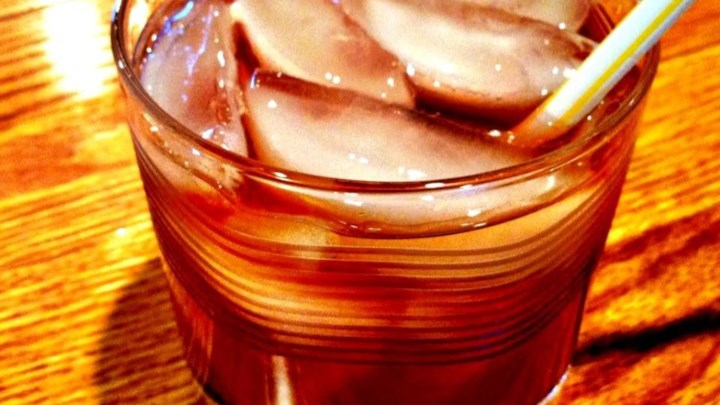

In [31]:
show_img(222886)

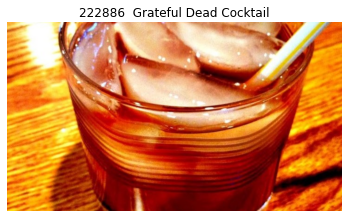

In [32]:
selected_recipe(222886)

time cost: 36.09621 sec


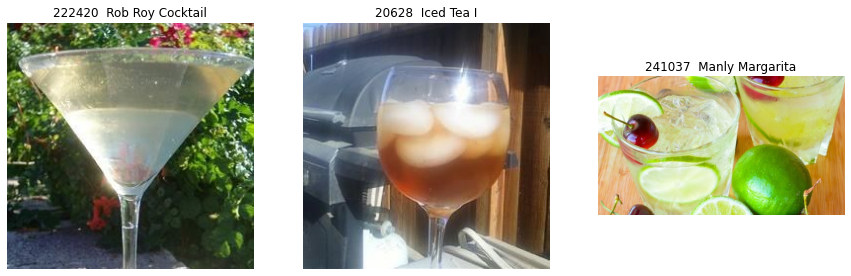

In [33]:
nutrition_ar, topN_ar = nutrition_hybrid_recommender(222886, ['aver_rate'], 3)

In [34]:
nutrition_ar

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222886,0.004609,0.000133,0.002110,0.000113,0.0,0.000081,0.00000
222420,0.004609,0.000000,0.002814,0.000113,0.0,0.000081,0.00000
20628,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
241037,0.004148,0.000133,0.002814,0.000113,0.0,0.000081,0.00028


In [35]:
topN_ar

,recipe_id,aver_rate,review_nums
46605,222420,5.00,1
46992,20628,4.28,26
46550,241037,4.00,3


time cost: 35.57573 sec


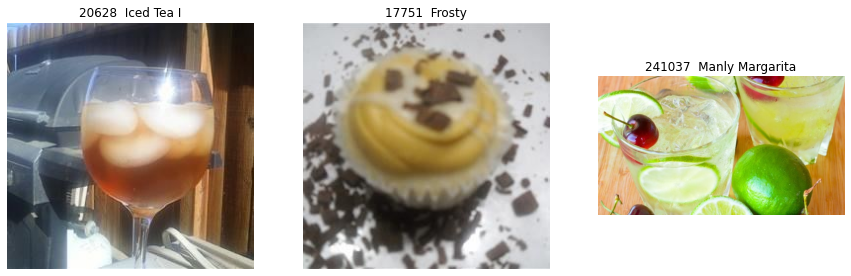

In [36]:
nutrition_rn, topN_rn = nutrition_hybrid_recommender(222886, ['review_nums'], 3)

In [37]:
nutrition_rn

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222886,0.004609,0.000133,0.002110,0.000113,0.0,0.000081,0.00000
20628,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
17751,0.000922,0.000133,0.002110,0.000113,0.0,0.000081,0.00000
241037,0.004148,0.000133,0.002814,0.000113,0.0,0.000081,0.00028


In [38]:
topN_rn

,recipe_id,aver_rate,review_nums
46992,20628,4.28,26
24213,17751,3.55,9
46550,241037,4.00,3
